In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, cross_validate, cross_val_predict
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from matplotlib import pyplot as plt
from numpy import mean, interp
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
data = pd.read_csv("caravan-insurance-challenge.csv")
train_data = data[data['ORIGIN'] == 'train']
test_data = data[data['ORIGIN'] == 'test']

train_data = train_data.drop(columns=['ORIGIN'])
test_data = test_data.drop(columns=['ORIGIN'])

accuracy_dict = {}

In [7]:
#Decision Tree
X_train = train_data.drop('CARAVAN', axis=1)
y_train = train_data['CARAVAN']
X_test = test_data.drop('CARAVAN', axis=1)
y_test = test_data['CARAVAN']

y_train = y_train.astype(float)
y_test = y_test.astype(float)

tree_classifier = DecisionTreeClassifier(random_state=0)

tree_classifier.fit(X_train, y_train)

predictions = tree_classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)

accuracy_dict["Decision Tree"] = accuracy
print("Accuracy of the model:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy of the model: 0.8935
Confusion Matrix:
 [[3540  222]
 [ 204   34]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.94      0.94      3762
         1.0       0.13      0.14      0.14       238

    accuracy                           0.89      4000
   macro avg       0.54      0.54      0.54      4000
weighted avg       0.90      0.89      0.90      4000



In [12]:
# Decision Tree With CV
X = train_data.drop('CARAVAN', axis=1)
y = train_data['CARAVAN'].astype(float)

tree_classifier2 = DecisionTreeClassifier(random_state=0)

# Perform k-fold cross-validation with 10 folds
k = 10
cv_results = cross_validate(tree_classifier2, X, y, cv=k, return_estimator=True, scoring='accuracy')

# Calculate average accuracy across all k-folds

print(f"Individual fold accuracies: {cv_results}")

best_estimator_idx = np.argmax(cv_results['test_score'])
best_model = cv_results['estimator'][best_estimator_idx]

predictions = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, predictions)

accuracy_dict["Decision Tree With CV"] = test_accuracy
print(f"Best model obtained from fold {best_estimator_idx+1} with accuracy: {cv_results['test_score'][best_estimator_idx]:.2f}")
print(f"Accuracy of the best model on the test set: {test_accuracy:.2f}")

Individual fold accuracies: {'fit_time': array([0.09703112, 0.08367109, 0.0691483 , 0.08469844, 0.08200955,
       0.07659602, 0.08157468, 0.07805204, 0.09795666, 0.09603524]), 'score_time': array([0.00399828, 0.00297403, 0.00300145, 0.00200105, 0.002002  ,
       0.00203562, 0.00199389, 0.0020349 , 0.00199842, 0.00203872]), 'estimator': [DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0), DecisionTreeClassifier(random_state=0)], 'test_score': array([0.87650086, 0.89708405, 0.89347079, 0.88659794, 0.89347079,
       0.87457045, 0.88487973, 0.8814433 , 0.89690722, 0.91408935])}
Best model obtained from fold 10 with accuracy: 0.91
Accuracy of the best model on the test set: 0.88


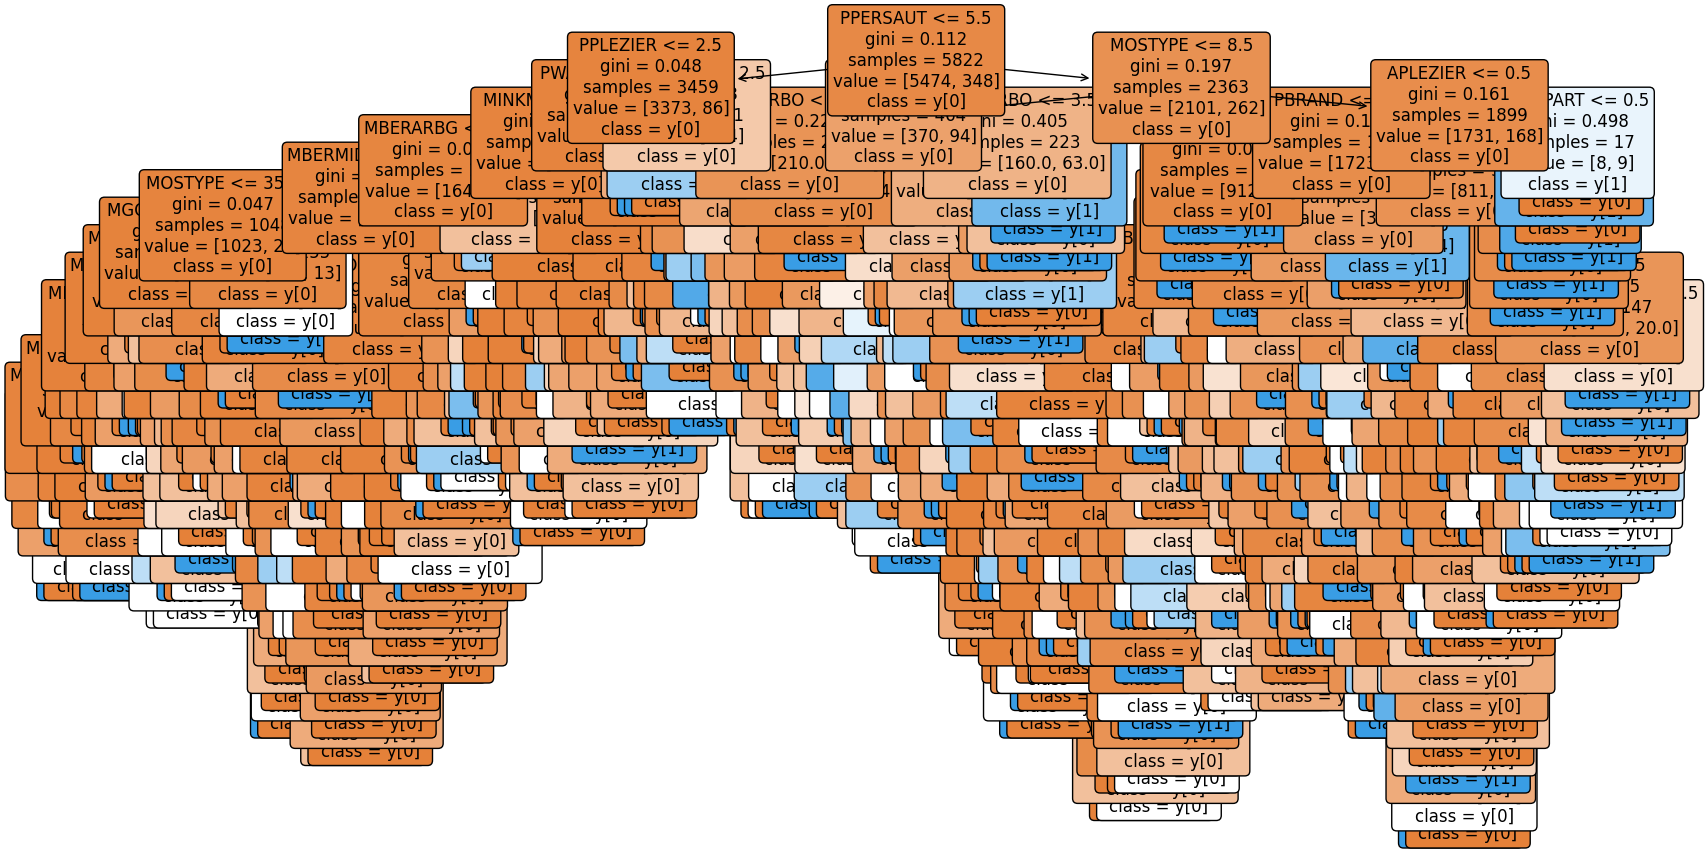

In [5]:
# Plotting the decision tree with matplotlib
plt.figure(figsize=(20,10))
plot_tree(tree_classifier, filled=True, feature_names=X_train.columns, class_names=True, rounded=True, fontsize=12)
plt.show()

In [6]:
# Decision Tree With Pruning
# Get the parameters of the best model
original_max_depth = best_model.tree_.max_depth

# Example of pruning: reduce the `max_depth` and increase `min_samples_leaf`
pruned_model = DecisionTreeClassifier(
    random_state=0,
    max_depth=max(1, 5),  # Reduce depth by 5
    min_samples_leaf=10                       # Require at least 10 samples per leaf
)

# Retrain the pruned model on the same training data
pruned_model.fit(X, y)

# Evaluate the pruned model on the test set
pruned_predictions = pruned_model.predict(X_test)
pruned_test_accuracy = accuracy_score(y_test, pruned_predictions)
accuracy_dict["Decision Tree With Pruning"] = pruned_test_accuracy
print(f"Accuracy of the pruned model on the test set: {pruned_test_accuracy:.2f}")


Accuracy of the pruned model on the test set: 0.94


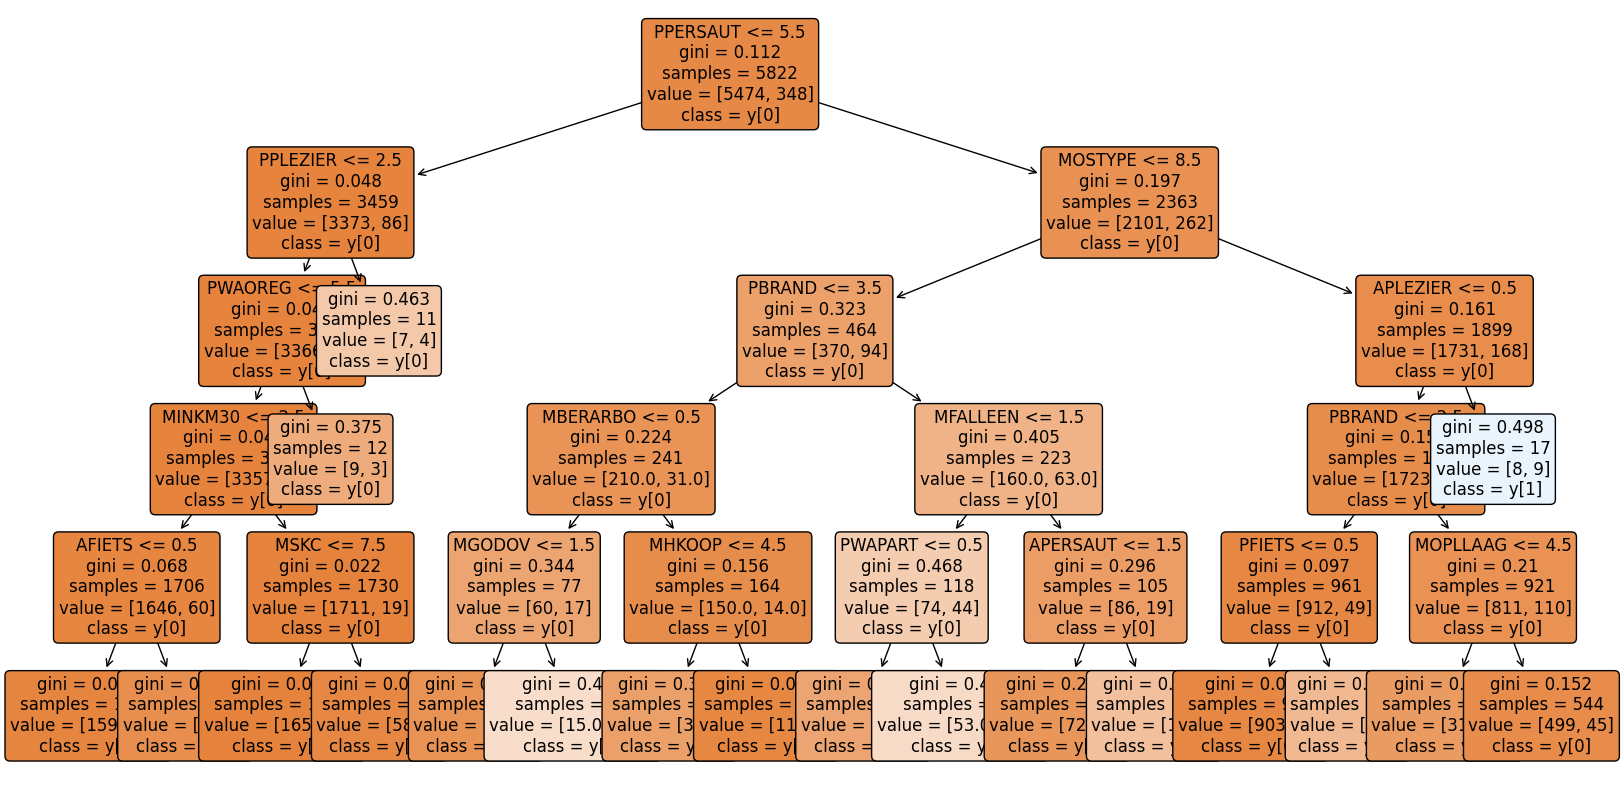

In [7]:
# Plotting the decision tree with matplotlib
plt.figure(figsize=(20,10))
plot_tree(pruned_model, filled=True, feature_names=X_train.columns, class_names=True, rounded=True, fontsize=12)
plt.show()

In [8]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust parameters as needed

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_classifier.predict(X_test)
y_prob = rf_classifier.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

# Calculate accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Generating a classification report and confusion matrix
clf_report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy_dict["Random Forest"] = accuracy
# Display the results
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:\n", clf_report)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.93225
ROC AUC Score: 0.6913093786158802

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.96      3762
         1.0       0.24      0.06      0.10       238

    accuracy                           0.93      4000
   macro avg       0.59      0.53      0.53      4000
weighted avg       0.90      0.93      0.91      4000


Confusion Matrix:
 [[3714   48]
 [ 223   15]]


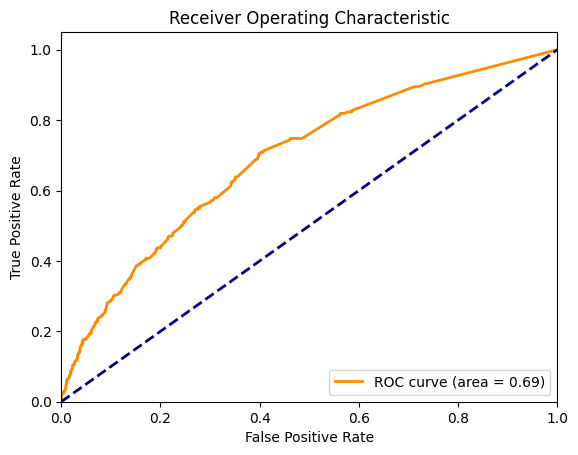

In [9]:
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the area under the ROC curve
roc_auc_value = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20, 30],  # Maximum depth of each tree
    'min_samples_split': [50, 100],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [25, 50],  # Minimum number of samples required to be at a leaf node
    'max_leaf_nodes': [500, 1000]  # Maximum number of leaf nodes
}

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Setup the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best ROC AUC Score:", grid_search.best_score_)

# Use the best estimator to make predictions
y_pred = grid_search.best_estimator_.predict(X_test)
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Calculate accuracy and ROC AUC score
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

# Generating a classification report and confusion matrix
clf_report = classification_report(y_test, y_pred, zero_division=0)
conf_matrix = confusion_matrix(y_test, y_pred)

accuracy_dict["Random Forest Grid Search"] = accuracy
# Display the results
print("Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:\n", clf_report)
print("\nConfusion Matrix:\n", conf_matrix)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'max_depth': 20, 'max_leaf_nodes': 500, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 200}
Best ROC AUC Score: 0.754783225477337
Accuracy: 0.9405
ROC AUC Score: 0.7396180960422446

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      3762
         1.0       0.00      0.00      0.00       238

    accuracy                           0.94      4000
   macro avg       0.47      0.50      0.48      4000
weighted avg       0.88      0.94      0.91      4000


Confusion Matrix:
 [[3762    0]
 [ 238    0]]


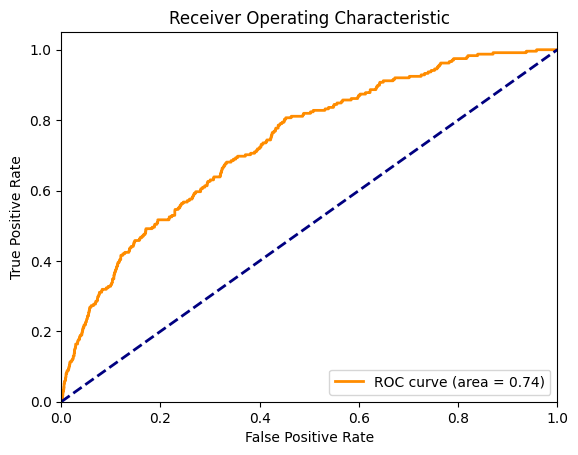

In [15]:
# Calculate the ROC curve points
fpr2, tpr2, thresholds2 = roc_curve(y_test, y_prob2)

# Calculate the area under the ROC curve
roc_auc_value2 = auc(fpr2, tpr2)

# Plot the ROC curve
plt.figure()
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_value2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [11]:
#Plain Logistic
logreg = LogisticRegression(solver='liblinear', random_state=42)

k_fold = KFold(n_splits=20, shuffle=True, random_state=42)

scores = cross_val_score(logreg, X_train, y_train, cv=k_fold, scoring='accuracy')
predicted = cross_val_predict(logreg, X_train, y_train, cv=k_fold, method='predict_proba')

average_accuracy = np.mean(scores)
print("Average Accuracy:", average_accuracy)

logreg.fit(X_train, y_train)

# Predict on the test data
y_test_pred = logreg.predict(X_test)
y_test_proba = logreg.predict_proba(X_test)

# Evaluate the model on the test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_roc_auc = roc_auc_score(y_test, y_test_proba[:, 1])
test_clf_report = classification_report(y_test, y_test_pred)
accuracy_dict["Logistic Regression"] = test_accuracy
print("Test Accuracy:", test_accuracy)
print("Test ROC AUC Score:", test_roc_auc)
print("\nTest Classification Report:\n", test_clf_report)

Average Accuracy: 0.93885338699807
Test Accuracy: 0.94
Test ROC AUC Score: 0.7282131353338783

Test Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      3762
         1.0       0.38      0.01      0.02       238

    accuracy                           0.94      4000
   macro avg       0.66      0.51      0.50      4000
weighted avg       0.91      0.94      0.91      4000



In [16]:
# Logistic Regression with RFE feature selection

logreg = LogisticRegression(solver='liblinear', random_state=42)

# Set up K-fold cross-validation
k_fold = KFold(n_splits=20, shuffle=True, random_state=42)

# Initialize RFE with logistic regression model and desired number of features
selector = RFE(logreg, n_features_to_select=5)  # Adjust the number of features according to your dataset

# Fit RFE
selector = selector.fit(X_train, y_train)

# Check selected features - optional
selected_features = X_train.columns[selector.support_]
print("Selected Features:", selected_features)
print("Ranking of features:", selector.ranking_)

# Perform cross-validation with selected features
scores = cross_val_score(selector, X_train, y_train, cv=k_fold, scoring='accuracy')
predicted = cross_val_predict(selector, X_train, y_train, cv=k_fold, method='predict_proba')

average_accuracy = np.mean(scores)
print("Average Accuracy:", average_accuracy)

roc_auc = roc_auc_score(y_train, predicted[:, 1])
print("ROC AUC Score:", roc_auc)

y_pred = cross_val_predict(selector, X_train, y_train, cv=k_fold)
clf_report = classification_report(y_train, y_pred)

accuracy_dict["Logistic Regression RFE"] = average_accuracy
print("\nClassification Report:\n", clf_report)

Selected Features: Index(['PWAPART', 'AWAPART', 'ABROM', 'APLEZIER', 'ABYSTAND'], dtype='object')
Ranking of features: [53 25 67 34 52 51 76 77 66 38 65 44 63 61 62 64 56 35 60 69 10 58 71 59
 74 80 75 57 79 11 12 45 46 47 37 36 42 41 40 39 32 43 54  1 31 17 24 72
 49  7 16 28  3 78 27 19  5 18 14 50 33 23  9 81  1 30 68 73 15 48 55 21
 22 29  1 26 70  6  2 13 20  1  4  8  1]
Average Accuracy: 0.9402279574448054
ROC AUC Score: 0.5975035066500363

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      5474
         1.0       0.50      0.00      0.01       348

    accuracy                           0.94      5822
   macro avg       0.72      0.50      0.49      5822
weighted avg       0.91      0.94      0.91      5822



In [13]:
# KNN with K-Fold Cross-Validation

# Set up K-Fold cross-validation
k_fold = KFold(n_splits=20, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)  # You can tune the number of neighbors

# Train the model using K-Fold CV and evaluate
accuracy_scores = cross_val_score(knn, X_train, y_train, cv=k_fold, scoring='accuracy')
predicted_probs = cross_val_predict(knn, X_train, y_train, cv=k_fold, method='predict_proba')

# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print("Average Accuracy:", average_accuracy)

# Calculate ROC AUC Score using cross-validated predictions
roc_auc = roc_auc_score(y_train, predicted_probs[:, 1])  # Probability for the positive class
print("ROC AUC Score:", roc_auc)

# Get a detailed classification report
y_pred = cross_val_predict(knn, X_train, y_train, cv=k_fold)
clf_report = classification_report(y_train, y_pred)

accuracy_dict["KNN"] = average_accuracy
print("\nClassification Report:\n", clf_report)

Average Accuracy: 0.9349026738219649
ROC AUC Score: 0.596211610581264

Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      5474
         1.0       0.12      0.01      0.03       348

    accuracy                           0.93      5822
   macro avg       0.53      0.50      0.50      5822
weighted avg       0.89      0.93      0.91      5822



In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
lda_predictions = lda.predict(X_test)

# Evaluating LDA
lda_conf_matrix = confusion_matrix(y_test, lda_predictions)
lda_class_report = classification_report(y_test, lda_predictions)
lda_accuracy = accuracy_score(y_test, lda_predictions)

accuracy_dict["LDA"] = lda_accuracy
print("LDA Confusion Matrix:")
print(lda_conf_matrix)
print("\nLDA Classification Report:")
print(lda_class_report)
print("\nLDA Accuracy:")
print(lda_accuracy)



LDA Confusion Matrix:
[[3731   31]
 [ 229    9]]

LDA Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97      3762
         1.0       0.23      0.04      0.06       238

    accuracy                           0.94      4000
   macro avg       0.58      0.51      0.52      4000
weighted avg       0.90      0.94      0.91      4000


LDA Accuracy:
0.935

QDA Confusion Matrix:
[[ 184 3578]
 [   5  233]]

QDA Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.05      0.09      3762
         1.0       0.06      0.98      0.12       238

    accuracy                           0.10      4000
   macro avg       0.52      0.51      0.10      4000
weighted avg       0.92      0.10      0.09      4000


QDA Accuracy:
0.10425


c:\Users\Vansh\Desktop\Stat 432\myenv\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [ ]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
qda_predictions = qda.predict(X_test)

# Evaluating QDA
qda_conf_matrix = confusion_matrix(y_test, qda_predictions)
qda_class_report = classification_report(y_test, qda_predictions)
qda_accuracy = accuracy_score(y_test, qda_predictions)

print("\nQDA Confusion Matrix:")
print(qda_conf_matrix)
print("\nQDA Classification Report:")
print(qda_class_report)
print("\nQDA Accuracy:")
print(qda_accuracy)